In [16]:
# Standard Imports
import pandas as pd
%matplotlib inline 
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot


# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


# Utilities
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

from imblearn.under_sampling import RandomUnderSampler


In [17]:
X_train = pd.read_csv('../6-X_train_FINAL.csv')
X_test = pd.read_csv('../6-X_test_FINAL.csv')
X_train=X_train.drop(['MAKE', 'VIN'], axis=1)
X_test=X_test.drop(['MAKE', 'VIN'], axis=1)

In [18]:
# Dropping Nulls
X_train = X_train.dropna(axis=0)
X_test = X_test.dropna(axis=0)

In [19]:
X_train = X_train[X_train['GVW_TYPE'].notna()]
X_test = X_test[X_test['GVW_TYPE'].notna()]

X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(int)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(int)

X_train['VEHICLE_TYPE'] = X_train['VEHICLE_TYPE'].astype(str)
X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(str)
X_train['FINAL_CYL'] = X_train['FINAL_CYL'].astype(str)
X_train['OBD_MIL_STATUS'] = X_train['OBD_MIL_STATUS'].astype(bool)

X_test['VEHICLE_TYPE'] = X_test['VEHICLE_TYPE'].astype(str)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(str)
X_test['FINAL_CYL'] = X_test['FINAL_CYL'].astype(str)
X_test['OBD_MIL_STATUS'] = X_test['OBD_MIL_STATUS'].astype(bool)

In [20]:
X_train.OBD_MIL_STATUS.value_counts()


True     115712
False      3597
Name: OBD_MIL_STATUS, dtype: int64

In [21]:
# getting target feature
y_train = X_train['OVERALL_RESULT']
X_train = X_train.drop('OVERALL_RESULT', axis='columns')
y_train = LabelEncoder().fit_transform(y_train)

y_test = X_test['OVERALL_RESULT']
X_test = X_test.drop('OVERALL_RESULT', axis='columns')
y_test = LabelEncoder().fit_transform(y_test)

In [22]:
print(len(X_train))
print(len(y_train))

119309
119309


In [23]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline


def cross_validate(cv, balancing_technique, model, param_grid, categorical_columns = None):
    pipeline = Pipeline([('balancing', balancing_technique), ('classifier', model)])

    if (categorical_columns != None) :
        print(':::::::CATEGORICAL FEATURES FOUND:::::::')
        cat_pipe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
        )

        preprocessor_linear = make_column_transformer(
            (cat_pipe, categorical_columns),
            n_jobs=2,
        )

        pipeline = Pipeline([('balancing', balancing_technique), ('preprocess', preprocessor_linear), ('classifier', model)])


    search = GridSearchCV((pipeline), param_grid, cv=cv)


    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        search.fit(X_t, y_t)
        y_hat_t = search.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = search.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))



        print('feature importance', search.best_estimator_.named_steps["classifier"].feature_importances_)

    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')
    print('\n')
    print('Grid Search Best Params:')
    print('\n')
    print(search.best_params_)



# Using different balancing techniques

## Undersampling

:::::::CATEGORICAL FEATURES FOUND:::::::
feature importance [0.17594491 0.1806867  0.0033087  0.04205086 0.00172498 0.03592661
 0.02414803 0.02410269 0.071838   0.05971476 0.02409151 0.04326462
 0.02143467 0.06590875 0.08465636 0.08728907 0.03711654 0.01679223]
feature importance [0.15061454 0.13826975 0.00080217 0.09176422 0.05514726 0.01483179
 0.01519066 0.07831944 0.07352161 0.03411814 0.03605153 0.02326971
 0.04289902 0.06385756 0.1052735  0.05330658 0.02276253]
feature importance [0.15945615 0.20910266 0.         0.         0.13090248 0.
 0.11916202 0.02114206 0.0180637  0.06785737 0.04867965 0.01642137
 0.01346193 0.04019534 0.01980034 0.05056126 0.0688256  0.01315768
 0.00321039]
feature importance [0.17585531 0.18361101 0.00481296 0.08897723 0.07967161 0.01747028
 0.01440497 0.05270279 0.06321814 0.0351133  0.03599723 0.02364019
 0.05835548 0.06555591 0.04159012 0.04437477 0.0146487 ]
feature importance [0.13224374 0.13302612 0.00188819 0.0011533  0.08448028 0.00205825
 0.0015

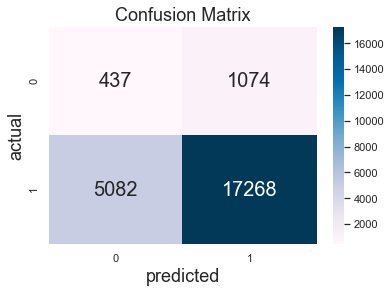

None
Training Accuracy: 0.6969611641839737


Validation Accuracy: 0.6964608331722697




Grid Search Best Params:


{'classifier__max_depth': 70, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [27]:
#Random Forest as model chosen
model = RandomForestClassifier()
#Balancing technique: UnderSampling
balancing_technique = RandomUnderSampler(random_state=0)
#Categorical features
categorical_columns = ['TRANS_TYPE','FUEL_TYPE', 'DUAL_EXHAUST', 'GVW_TYPE','VEHICLE_TYPE']
#Evaluating the model
rand_forest_parms = {'classifier__n_estimators': [100],
                     'classifier__max_depth':[6, 25, 50, 70],
                     'classifier__min_samples_split': [2, 5, 10],
                     'classifier__min_samples_leaf': [1, 2, 10]}
cross_validate(KFold(), balancing_technique, model,rand_forest_parms, categorical_columns)

## Oversampling